# SV-eQTL analysis

# Imports and Consts

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET_PAH = "./Dataset/"
RNAFILENAME = "GD660.GeneQuantRPKM.txt"
VCFFILENAME = "ALL.wgs.mergedSV.v8.20130502.svs.genotypes.vcf"
CHOSEN_CHROMOSOME = 19

# Load and prepare data

In [3]:
rnaSeqData = pd.read_csv(DATASET_PAH + RNAFILENAME, delimiter="\t")

In [4]:
rnaSeqData

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.94950,0.95837,0.51002,0.29422,0.22960,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53929,ENSG00000172297.6,ENSG00000172297.6,Y,27600708,0.13907,0.10224,0.00000,0.08924,0.19945,0.00000,...,0.07151,0.00000,0.18889,0.08700,0.15464,0.13199,0.19273,0.15151,0.11010,0.15483
53930,ENSG00000259738.1,ENSG00000259738.1,15,59157205,0.00000,0.13191,0.00000,0.00000,0.15789,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53931,ENSG00000212040.1,ENSG00000212040.1,14,101498324,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
53932,ENSG00000125266.5,ENSG00000125266.5,13,107187462,0.12923,0.07601,0.32377,0.25588,0.05295,0.16194,...,0.34558,0.12560,0.22624,0.08303,0.15089,0.09111,0.13432,0.19148,0.05730,0.12557


In [5]:
f = open(DATASET_PAH + VCFFILENAME, "r")
columns = None
for l in f:
    if "#CHROM" in l:
        columns = l.split("\t")
        break

In [6]:
columns[0] = columns[0].replace("#", "")

In [7]:
columns[len(columns) - 1] = columns[len(columns) - 1].replace("\n", "")

In [8]:
vcfSourceFile = pd.read_csv(
    DATASET_PAH + VCFFILENAME,
    sep="\t",
    comment="#",
    names=columns,
    header=None,
)

/tmp/ipykernel_189579/242614598.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcfSourceFile = pd.read_csv(


There are groups of values in 'ALT' column that need to be split

In [9]:
vcfSourceFile[vcfSourceFile["CHROM"] == CHOSEN_CHROMOSOME]["ALT"].unique()

array(['<CN2>', '<CN0>,<CN2>', '<CN0>', 'G', 'A', 'C', '<INS:ME:ALU>',
       '<INS:ME:SVA>', 'T', '<CN0>,<CN2>,<CN3>', '<INV>', '<INS:MT>',
       '<CN2>,<CN3>', '<INS:ME:LINE1>'], dtype=object)

In [10]:
def processChr(row):
    if row["Chr"] not in ["X", "Y", "M"]:
        row["Chr"] = str(row["Chr"])
    return row


rnaSeqData = rnaSeqData.apply(lambda x: processChr(x), axis=1)

In [11]:
rnaSeqData["Chr"].unique()

array(['11', '6', '15', '16', 'Y', '4', '1', '7', '10', '22', '20', '14',
       '2', '8', '9', '12', '19', '17', '21', '5', '13', '3', 'X', '18',
       'M'], dtype=object)

In [12]:
def processCHROM(row):
    if row["CHROM"] not in ["X", "Y", "M"]:
        row["CHROM"] = str(row["CHROM"])
    return row


vcfSourceFile = vcfSourceFile.apply(lambda x: processCHROM(x), axis=1)

vcfSourceFile["CHROM"].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X'],
      dtype=object)

Investigating the number of datapoints for each chromosome to choose one with reasonable size

In [13]:
vcfSourceFile.groupby(by="CHROM").size()

CHROM
1     4671
10    3126
11    3375
12    3299
13    2485
14    2097
15    1867
16    2062
17    1926
18    2005
19    1621
2     5642
20    1569
21     877
22     848
3     4811
4     4780
5     4425
6     4187
7     4200
8     3681
9     3001
X     2263
dtype: int64

In [14]:
rnaSeqData.groupby(by="Chr").size()

Chr
1     5172
10    2199
11    3121
12    2747
13    1185
14    2182
15    2021
16    2292
17    2207
18     562
19    1939
2     3872
20    1276
21     694
22    1187
3     2917
4     2494
5     2734
6     2794
7     2770
8     2315
9     2334
M       37
X     2328
Y      555
dtype: int64

In [15]:
vcfSourceFile.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'HG00096',
       ...
       'NA21128', 'NA21129', 'NA21130', 'NA21133', 'NA21135', 'NA21137',
       'NA21141', 'NA21142', 'NA21143', 'NA21144'],
      dtype='object', length=2513)

In [16]:
vcfSourceFile["CHROM"] = vcfSourceFile["CHROM"].apply(lambda x: str(x))
# I pick only 1 chromosome to make sure the computation time is reasonable
vcfSourceFile = vcfSourceFile[vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)].copy()

In [17]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
61640,19,251548,DUP_gs_CNV_19_251548_283564,C,<CN2>,.,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61641,19,266428,DUP_uwash_chr19_266428_341459,T,<CN2>,.,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61642,19,286841,DUP_gs_CNV_19_286841_307454,T,"<CN0>,<CN2>",.,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61643,19,293937,BI_GS_DEL1_B2_P2673_28,G,<CN0>,100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
61644,19,323368,DUP_gs_CNV_19_323368_334484,A,"<CN0>,<CN2>",.,PASS,"AC=1,8;AF=0.00019968,0.00159744;AFR_AF=0,0.002...",GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63256,19,58999008,SVA_umary_SVA_769,T,<INS:ME:SVA>,.,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63257,19,59015810,BI_GS_DEL1_B2_P2732_9,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63258,19,59020256,UW_VH_3019,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
63259,19,59021221,BI_GS_DEL1_B5_P2732_16,T,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [18]:
newColumns = []
for i in range(len(rnaSeqData.columns)):
    newColumns.append(rnaSeqData.columns[i].split(".")[0])

In [19]:
rnaSeqData.columns = newColumns

In [20]:
rnaSeqData = rnaSeqData[rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)].copy()

In [21]:
rnaSeqData = rnaSeqData.loc[:, ~rnaSeqData.columns.duplicated()].copy()

In [22]:
commonColumns = rnaSeqData.columns.intersection(vcfSourceFile.columns)

In [23]:
commonColumns

Index(['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101', 'HG00102',
       'HG00103', 'HG00105', 'HG00106', 'HG00108',
       ...
       'NA20809', 'NA20810', 'NA20811', 'NA20812', 'NA20813', 'NA20814',
       'NA20815', 'NA20819', 'NA20826', 'NA20828'],
      dtype='object', length=445)

In [24]:
vcfSourceFile["QUAL"] = vcfSourceFile["QUAL"].apply(lambda x: int(x) if x != "." else 0)
# vcfSourceFile = vcfSourceFile[vcfSourceFile["QUAL"] > 90]
# Filtering by quality significantly reduces the amount of unique SVs, so I refrain from doing so

In [25]:
vcfSourceFile["ALT"] = vcfSourceFile["ALT"].apply(lambda x: x.split(","))

In [26]:
import warnings

warnings.filterwarnings("ignore")

The aim is to investigate the effect of each SV separately, so for each element in the ALT column I prepare the appropriate X and y vectors assuming that 0|0 -> 0, x|0 -> 1, 0|x -> 1, x|x -> 2

In [27]:
def processRow(row, allRows):
    rows = []
    for i in range(len(row["ALT"])):
        # for each element split each common column by | and if any value in ALT is bigger than i+1 set it to -1
        rows.append(row.copy())
        rows[i]["ALT"] = rows[i]["ALT"][i]
        for column in commonColumns:
            vals = row[column].split("|")
            if not (int(vals[0]) == 0 or int(vals[0]) == i + 1) or not (
                int(vals[1]) == 0 or int(vals[1]) == i + 1
            ):
                rows[i][column] = -1
            else:
                rows[i][column] = sum(np.array(vals, dtype=np.int64)) / (i + 1)
        allRows.append(rows[i].to_numpy())

In [28]:
allRows = []
_ = vcfSourceFile.apply(lambda x: processRow(x, allRows), axis=1)

In [29]:
vcfSourceFile = pd.DataFrame(allRows, columns=vcfSourceFile.columns)

In [30]:
for column in commonColumns:
    vcfSourceFile[column] = vcfSourceFile[column].apply(lambda x: int(x))

In [31]:
vcfSourceFile

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA21128,NA21129,NA21130,NA21133,NA21135,NA21137,NA21141,NA21142,NA21143,NA21144
0,19,251548,DUP_gs_CNV_19_251548_283564,C,<CN2>,0,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1,19,266428,DUP_uwash_chr19_266428_341459,T,<CN2>,0,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
2,19,286841,DUP_gs_CNV_19_286841_307454,T,<CN0>,0,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
3,19,286841,DUP_gs_CNV_19_286841_307454,T,<CN2>,0,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
4,19,293937,BI_GS_DEL1_B2_P2673_28,G,<CN0>,100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,19,58999008,SVA_umary_SVA_769,T,<INS:ME:SVA>,0,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1728,19,59015810,BI_GS_DEL1_B2_P2732_9,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1729,19,59020256,UW_VH_3019,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
1730,19,59021221,BI_GS_DEL1_B5_P2732_16,T,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [32]:
rnaSeqData = rnaSeqData.reset_index()

Finding 3 closest RNA elements for each gene

In [33]:
def findClosestRna(rnaRow, closestRna, vcfRow):
    distance = np.abs(vcfRow["POS"] - rnaRow["Coord"])
    closestRna.append([distance, rnaRow.name])


def mergeRnaOnClosest(row, rna):
    closestRna = []
    rna.apply(lambda x: findClosestRna(x, closestRna, row), axis=1)
    # Merge on closestRna
    # print(closestRna["closest"])

    closestRnaDf = pd.DataFrame(closestRna, columns=["Distance", "Name"])

    row["RNAIndex"] = (
        closestRnaDf.sort_values(by="Distance", ascending=True)
        .head(3)["Name"]
        .to_list()
    )
    return row


vcfSourceFile = vcfSourceFile.reset_index()
vcfRnaMerged = vcfSourceFile.apply(
    lambda x: mergeRnaOnClosest(x, rnaSeqData), axis=1
).reset_index()

In [34]:
vcfRnaMerged = vcfRnaMerged.explode("RNAIndex")

In [35]:
vcfRnaMerged["RNAIndex"]

0       1829
0        691
0       1456
1        691
1       1829
        ... 
1730    1900
1730    1045
1731    1900
1731     457
1731    1122
Name: RNAIndex, Length: 5196, dtype: object

In [36]:
rnaBaseColumns = ["TargetID", "Gene_Symbol", "Chr", "Coord"]
vcfBaseColumns = [
    "CHROM",
    "POS",
    "ID",
    "REF",
    "ALT",
    "QUAL",
    "FILTER",
    "INFO",
    "FORMAT",
]

In [37]:
vcfRnaMerged["ALT"].unique()

array(['<CN2>', '<CN0>', 'G', 'A', 'C', '<INS:ME:ALU>', '<INS:ME:SVA>',
       'T', '<CN3>', '<INV>', '<INS:MT>', '<INS:ME:LINE1>'], dtype=object)

In [38]:
vcfSourceFile[vcfBaseColumns + list(commonColumns)][
    vcfSourceFile["CHROM"] == str(CHOSEN_CHROMOSOME)
]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
0,19,251548,DUP_gs_CNV_19_251548_283564,C,<CN2>,0,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,19,266428,DUP_uwash_chr19_266428_341459,T,<CN2>,0,PASS,AC=4;AF=0.00079872;AFR_AF=0.0015;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,19,286841,DUP_gs_CNV_19_286841_307454,T,<CN0>,0,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0,...,0,0,0,0,0,0,0,0,0,0
3,19,286841,DUP_gs_CNV_19_286841_307454,T,<CN2>,0,PASS,"AC=3,3;AF=0.00059904,0.00059904;AFR_AF=0.0015,...",GT,0,...,0,0,0,0,0,0,0,0,0,0
4,19,293937,BI_GS_DEL1_B2_P2673_28,G,<CN0>,100,PASS,AC=8;AF=0.00159744;AFR_AF=0.0015;AMR_AF=0.0029...,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,19,58999008,SVA_umary_SVA_769,T,<INS:ME:SVA>,0,.,AC=6;AF=0.00119808;AFR_AF=0.0045;AMR_AF=0;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0
1728,19,59015810,BI_GS_DEL1_B2_P2732_9,G,<CN0>,100,PASS,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
1729,19,59020256,UW_VH_3019,C,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...,GT,0,...,0,0,0,0,0,0,0,0,0,0
1730,19,59021221,BI_GS_DEL1_B5_P2732_16,T,<CN0>,100,PASS,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0.0014;AN=5...,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
rnaSeqData[rnaBaseColumns + list(commonColumns)][
    rnaSeqData["Chr"] == str(CHOSEN_CHROMOSOME)
]

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
0,ENSG00000243642.1,ENSG00000243642.1,19,58581338,0.00000,0.00000,0.00000,0.00000,0.00000,0.21415,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,ENSG00000221504.1,ENSG00000221504.1,19,32417479,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000105357.9,ENSG00000105357.9,19,50706885,0.00000,0.00893,0.01107,0.00000,0.00000,0.00000,...,0.01808,0.00000,0.00958,0.00773,0.00000,0.00928,0.01433,0.01631,0.00593,0.00000
3,ENSG00000131037.8,ENSG00000131037.8,19,55583407,0.30019,0.36200,0.43385,0.35353,0.24540,0.06797,...,0.27190,0.27774,0.37089,0.25377,0.24257,0.11613,0.05664,0.39721,0.44654,0.20085
4,ENSG00000007255.5,ENSG00000007255.5,19,45681485,20.41195,19.88715,19.50962,13.88066,13.49203,3.20345,...,29.79700,18.38779,14.77266,14.41909,21.12137,6.88149,10.83442,22.96336,19.30111,9.72888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,ENSG00000213996.3,ENSG00000213996.3,19,19384074,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1935,ENSG00000244253.1,ENSG00000244253.1,19,40079595,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1936,ENSG00000130309.4,ENSG00000130309.4,19,17666460,11.26085,10.45836,13.02215,11.28219,13.15124,6.49617,...,18.04743,14.34539,12.72421,14.71541,10.31135,11.17458,15.14622,11.52041,11.30648,9.77187
1937,ENSG00000083842.6,ENSG00000083842.6,19,58790318,2.14528,2.32057,2.45383,1.55192,2.37085,1.49983,...,1.17241,1.12695,2.22265,1.72124,1.40424,1.09540,1.84351,1.87085,1.79343,1.64816


# Perform linear regression

In [40]:
vcfRnaMerged.iloc[400]["ALT"]

'<INS:ME:ALU>'

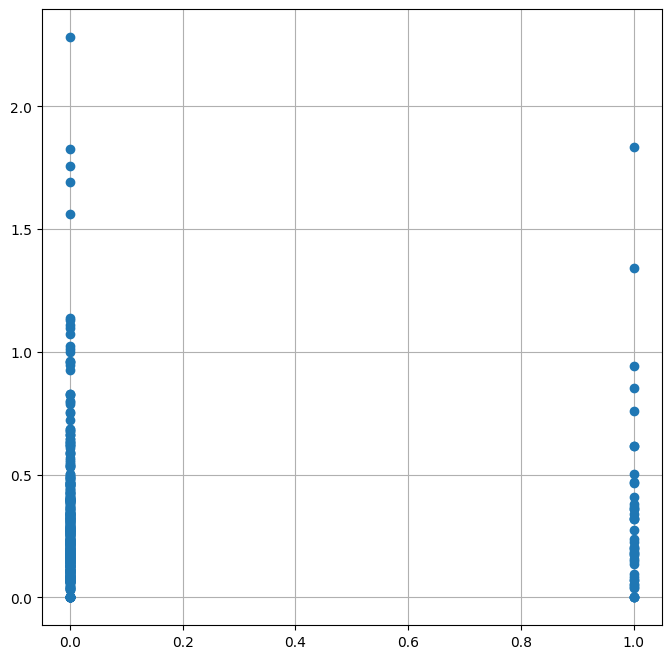

In [51]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(
    x=vcfRnaMerged.iloc[400][commonColumns].astype(int).to_frame().T.to_numpy()[0],
    y=rnaSeqData.iloc[vcfRnaMerged.iloc[400]["RNAIndex"]][commonColumns],
)
ax.grid()
ax.set_axisbelow(True)
plt.show()

# The goal is to fit a line to such data, in some cases there will be also "2" x

In [42]:
p_values = {}
for index, row in vcfRnaMerged.iterrows():
    numpy_data = np.array(
        [
            row[commonColumns].astype(int).to_frame().T.to_numpy()[0],
            rnaSeqData.iloc[row["RNAIndex"]][commonColumns],
        ]
    )

    df = pd.DataFrame(data=numpy_data).T
    df.columns = ["x", "y"]
    df = df[df["x"] != -1]
    mod = statsmodels.api.OLS(
        np.asarray(df["y"], dtype=np.float64),
        df["x"].astype(float).to_frame().T.to_numpy()[0],
    )
    fii = mod.fit()

    p_values[row.name] = fii.summary2().tables[1]["P>|t|"]

In [43]:
p_values = {k: v.to_numpy()[0] for k, v in p_values.items() if v.to_numpy()[0] <= 0.05}

In [44]:
d = {}
for key in p_values.keys():
    d[key] = {}
    d[key]["GENEPOS"] = vcfRnaMerged.iloc[key]["POS"]
    d[key]["GENEID"] = vcfRnaMerged.iloc[key]["ID"]
    d[key]["ALT"] = vcfRnaMerged.iloc[key]["ALT"]
    d[key]["RNAID"] = rnaSeqData.iloc[vcfRnaMerged.iloc[key]["RNAIndex"]]["TargetID"]
    d[key]["RNACOORD"] = rnaSeqData.iloc[vcfRnaMerged.iloc[key]["RNAIndex"]]["Coord"]
    d[key]["SIG"] = p_values[key]

In [45]:
df = pd.DataFrame(d)

As a result 223 SV-eQTL have been discovered

In [46]:
pd.set_option("display.float_format", "{:.2g}".format)
df.T

,GENEPOS,GENEID,ALT,RNAID,RNACOORD,SIG
10,286841,DUP_gs_CNV_19_286841_307454,<CN2>,ENSG00000105556.3,344791,1.1e-99
13,293937,BI_GS_DEL1_B2_P2673_28,<CN0>,ENSG00000105556.3,344791,4e-22
14,293937,BI_GS_DEL1_B2_P2673_28,<CN0>,ENSG00000222329.1,223261,4e-22
18,323368,DUP_gs_CNV_19_323368_334484,<CN2>,ENSG00000105556.3,344791,0.036
19,323368,DUP_gs_CNV_19_323368_334484,<CN2>,ENSG00000141934.3,291435,0.0062
...,...,...,...,...,...,...
1655,19432449,BI_GS_DEL1_B2_P2692_279,<CN0>,ENSG00000213996.3,19384074,1.9e-05
1657,19436758,YL_CN_GWD_5232,<CN0>,ENSG00000105705.8,19431318,2.7e-06
1660,19454338,ALU_umary_ALU_11889,<INS:ME:ALU>,ENSG00000105705.8,19431318,0.00012
1692,19985453,DEL_pindel_48427,G,ENSG00000256771.1,19976714,0.0037


In [47]:
df.T.to_csv("regressionResults.csv")

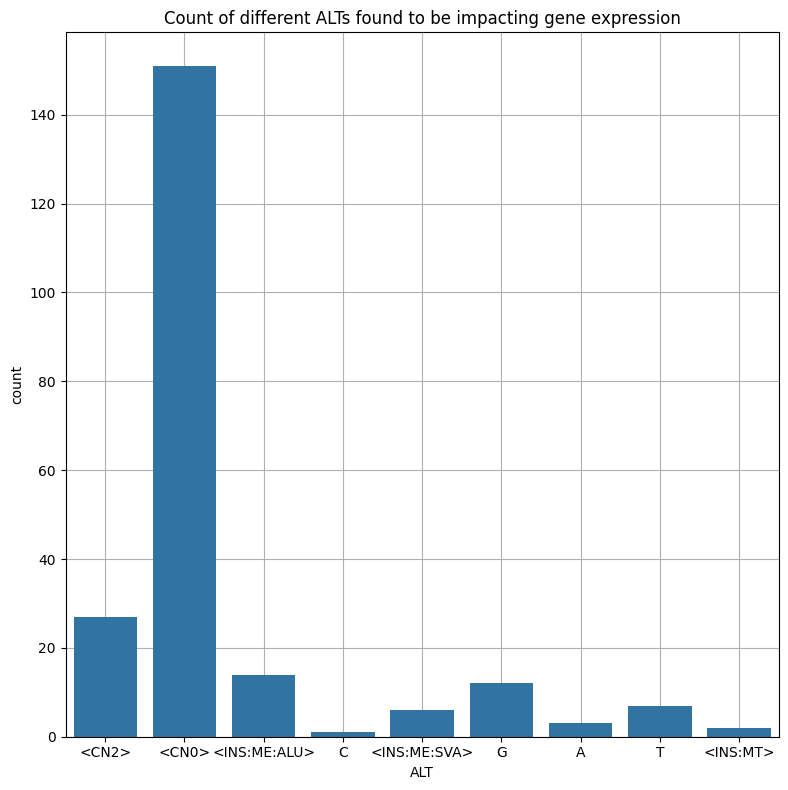

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title("Count of different ALTs found to be impacting gene expression")
sns.countplot(x="ALT", data=df.T)
plt.tight_layout()
ax.grid()
ax.set_axisbelow(True)
plt.show()